In [1]:
#importing the required packages
import os
import matplotlib.pyplot as plt
import numpy as np
from keras import backend
import argparse
import random
import cv2
import glob

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
from keras import applications
from keras import Model

In [4]:
dataset_path = "Data\\gender_dataset_face"
img_dims = (96,96,3)
data = []
labels = []

In [5]:
# load image files from the dataset
random.seed(42)
image_files = [f for f in glob.glob(dataset_path + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [6]:
# create groud-truth label from the image path
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label])

In [8]:
print(len(data))
print(len(labels))

10218
10218


In [9]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [10]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, 
                         width_shift_range=0.1,
                         height_shift_range=0.1, 
                         shear_range=0.2, 
                         zoom_range=0.2,
                         horizontal_flip=True, 
                         fill_mode="nearest")

In [11]:
print("training x length: ", len(trainX))
print("testing x length: ", len(testY))

training x length:  8174
testing x length:  2044


In [12]:
# initial parameters
epochs = 100
lr_rate = 0.0001
batch_size = 64
drop_out = 0.15

## VGG 19

In [13]:
#Creating a function for saving the model at each epoch end
class LossHistory(Callback):
    def __init__(self):
        super().__init__()
        self.epoch_id = 0
        self.losses = ''
 
    def on_epoch_end(self, epoch, logs={}):
        self.losses += "Epoch {}: accuracy -> {:.3f}, val_accuracy -> {:.3f}\n"\
            .format(str(self.epoch_id), logs.get('acc'), logs.get('val_acc'))
        self.epoch_id += 1
 
    def on_train_begin(self, logs={}):
        self.losses += 'Training begins...\n'

In [14]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_dims[0], img_dims[1], 3))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

In [17]:
len(model.layers)

22

In [18]:
for layer in model.layers:
    layer.trainable = False

In [19]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [20]:
# creating the final model 
model_final = Model(input = model.input, output = predictions)

C:\Users\NiranjanKumar\Anaconda3\envs\deepbackup\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  


In [21]:
# compile the model 
model_final.compile(loss = "binary_crossentropy", optimizer = SGD(lr=lr_rate, momentum=0.9), metrics=["accuracy"])

In [22]:
#summary of final model
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

In [23]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint(filepath = os.path.join('Detection\\Models', 'vgg19_1.h5'), monitor='val_acc', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [24]:
# Create a loss history 
#saving to text file
history = LossHistory()

In [25]:
# train the model
x = model_final.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, 
                        verbose=1, 
                        workers = 6, 
                        callbacks = [history, checkpoint], 
                        max_q_size = 100)

C:\Users\NiranjanKumar\Anaconda3\envs\deepbackup\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=127, max_queue_size=100, workers=6, validation_data=(array([[[..., verbose=1, callbacks=[<__main__..., epochs=100)`
  if __name__ == '__main__':


Epoch 1/100
127/127 [==============================] - 84s 665ms/step - loss: 0.5652 - acc: 0.7231 - val_loss: 0.3445 - val_acc: 0.8444

Epoch 00001: val_acc improved from -inf to 0.84442, saving model to Detection\Models\vgg19_1.h5
Epoch 2/100
127/127 [==============================] - 31s 243ms/step - loss: 0.4125 - acc: 0.8116 - val_loss: 0.3364 - val_acc: 0.8439

Epoch 00002: val_acc did not improve from 0.84442
Epoch 3/100
127/127 [==============================] - 31s 244ms/step - loss: 0.3984 - acc: 0.8189 - val_loss: 0.2926 - val_acc: 0.8620

Epoch 00003: val_acc improved from 0.84442 to 0.86204, saving model to Detection\Models\vgg19_1.h5
Epoch 4/100
127/127 [==============================] - 31s 244ms/step - loss: 0.3621 - acc: 0.8330 - val_loss: 0.2807 - val_acc: 0.8689

Epoch 00004: val_acc improved from 0.86204 to 0.86888, saving model to Detection\Models\vgg19_1.h5
Epoch 5/100
127/127 [==============================] - 31s 244ms/step - loss: 0.3516 - acc: 0.8469 - val_los


Epoch 00039: val_acc did not improve from 0.92172
Epoch 40/100
127/127 [==============================] - 31s 246ms/step - loss: 0.2404 - acc: 0.9003 - val_loss: 0.1939 - val_acc: 0.9159

Epoch 00040: val_acc did not improve from 0.92172
Epoch 41/100
127/127 [==============================] - 31s 247ms/step - loss: 0.2358 - acc: 0.9000 - val_loss: 0.1953 - val_acc: 0.9119357

Epoch 00041: val_acc did not improve from 0.92172
Epoch 42/100
127/127 [==============================] - 31s 247ms/step - loss: 0.2404 - acc: 0.9006 - val_loss: 0.1934 - val_acc: 0.9173

Epoch 00042: val_acc did not improve from 0.92172
Epoch 43/100
127/127 [==============================] - 31s 247ms/step - loss: 0.2407 - acc: 0.8976 - val_loss: 0.1907 - val_acc: 0.9159

Epoch 00043: val_acc did not improve from 0.92172
Epoch 44/100
127/127 [==============================] - 31s 246ms/step - loss: 0.2406 - acc: 0.8991 - val_loss: 0.1898 - val_acc: 0.9168

Epoch 00044: val_acc did not improve from 0.92172
Epoch 

127/127 [==============================] - 31s 246ms/step - loss: 0.2120 - acc: 0.9131 - val_loss: 0.1775 - val_acc: 0.9198

Epoch 00082: val_acc did not improve from 0.92613
Epoch 83/100
127/127 [==============================] - 31s 246ms/step - loss: 0.2108 - acc: 0.9096 - val_loss: 0.1780 - val_acc: 0.9227

Epoch 00083: val_acc did not improve from 0.92613
Epoch 84/100
127/127 [==============================] - 31s 246ms/step - loss: 0.2184 - acc: 0.9115 - val_loss: 0.1768 - val_acc: 0.9247

Epoch 00084: val_acc did not improve from 0.92613
Epoch 85/100
127/127 [==============================] - 31s 246ms/step - loss: 0.2054 - acc: 0.9139 - val_loss: 0.1760 - val_acc: 0.9237

Epoch 00085: val_acc did not improve from 0.92613
Epoch 86/100
127/127 [==============================] - 31s 246ms/step - loss: 0.2070 - acc: 0.9154 - val_loss: 0.1744 - val_acc: 0.9212

Epoch 00086: val_acc did not improve from 0.92613
Epoch 87/100
127/127 [==============================] - 31s 248ms/step - 

In [26]:
x.history.keys()

dict_keys(['acc', 'val_acc', 'val_loss', 'loss'])

In [27]:
plt.rcParams['figure.figsize'] = (15, 20)
plt.style.use("seaborn")

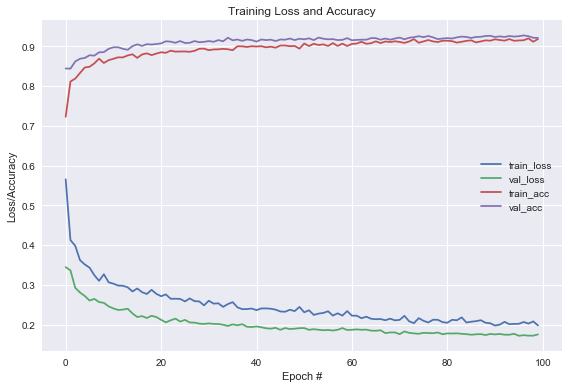

In [34]:
# plot training/validation loss/accuracy
N = epochs
plt.plot(np.arange(0,N), x.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), x.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), x.history["acc"], label="train_acc")
plt.plot(np.arange(0,N), x.history["val_acc"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.tight_layout()
plt.show()

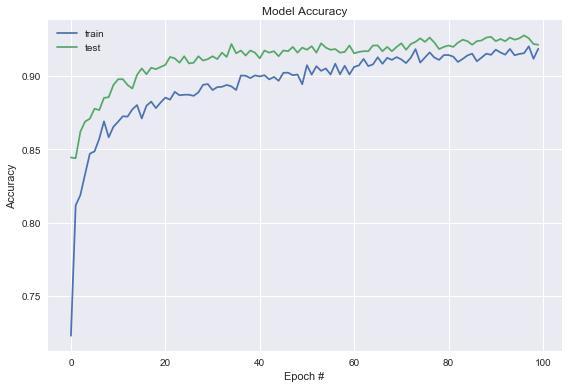

In [29]:
# summarize history for accuracy
plt.plot(x.history['acc'])
plt.plot(x.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

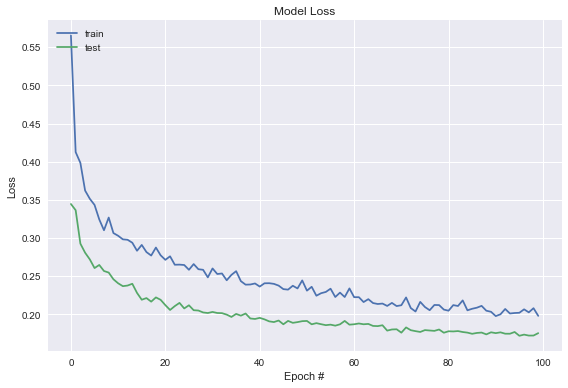

In [30]:
# summarize history for loss
plt.plot(x.history['loss'])
plt.plot(x.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

In [31]:
score = model_final.evaluate(testX, testY)
print("Accuracy on test data:", score[1])

2044/2044 [==============================] - 8s 4ms/step
Accuracy on test data: 0.921232876829


In [32]:
# Save loss history to file
loss_history_path = os.path.join('Detection\\Models', 'loss_history_transfer_vgg19.log')
myFile = open(loss_history_path, 'w+')
myFile.write(history.losses)
myFile.close()

In [35]:
backend.clear_session()